In [13]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import numpy as np
import itertools
from itertools import permutations, combinations
import time
from pylab import *

torch.manual_seed(1)                      # reproducible
torch.set_printoptions(threshold=np.inf)  # print all

def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]


# ----- Step 1: Set Hyper Parameters ----- #

NAME = 'DNN-IRIS'
OUTPUT_CLASS = 10

RELEASE_LISTS = [
    [2,3],
    [3,2]
]
RELEASE_FACTOR = 0.1

LR = 0.01
TURNS = 150

K = 3
T = 20

K_release = K-1
T_max = T-1


# ----- Step 2: Load MNIST Dataset and Create Loader ----- #

breast_cancer = load_breast_cancer()

X_train, X_test, Y_train, Y_test = train_test_split(breast_cancer.data, breast_cancer.target, test_size=0.25)
x_train, x_test = torch.tensor(X_train, dtype=torch.float), torch.tensor(X_test, dtype=torch.float)
y_train, y_test = torch.tensor(Y_train, dtype=torch.long), torch.tensor(Y_test, dtype=torch.long)

train_Y = y_train.numpy()
test_Y = y_test.numpy()

y_train_onehot = torch.nn.functional.one_hot(y_train, num_classes=10)


# ----- Step 3: Create Model Class ----- #

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = torch.nn.Linear(30, 32)
        self.l2 = torch.nn.Linear(32, 10)
    
    def forward(self, x):
        x = x.view(-1, 30)
        x = F.relu(self.l1(x))
        return self.l2(x)


# ----- Step 4: Instantiate ----- #

model = Net()
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

MS_loss_fn = torch.nn.MSELoss()


# ----- Step 5: Model Training ----- #

turns_record = []
loss_record = []
MS_loss_record = []
train_acc_record = []
F1_record = []
MCC_record = []
Score_record = []

total_loss_time = 0
total_MS_loss_time = 0
total_acc_time = 0
total_F1_time = 0
total_MCC_time = 0
total_Score_time = 0   

for turns in range(1, TURNS+1):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = loss_fn(outputs, y_train)  # criterion
    loss.backward()        # backward and compute gradients
    optimizer.step()       # apply gradients

    # Shared Part - train_output
    SP_trainout_time_part_start = time.time()
    train_output = model(x_train)
    SP_trainout_time_part_stop = time.time()

    # Shared Part - softmax
    SP_softmax_time_part_start = time.time()
    train_output_result = F.softmax(train_output, dim=1)  # softmax in last dim
    SP_softmax_time_part_stop = time.time()

    # Shared Part - pred_train_y
    SP_predy_time_part_start = time.time()
    pred_train_y = torch.max(train_output, 1)[1].data.numpy()
    SP_predy_time_part_stop = time.time()

    # Acc
    acc_time_part_start = time.time()
    train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
    acc_time_part_stop = time.time()

    # MS Loss
    MS_loss_time_part_start = time.time()
#     print(train_output_result)
    MS_train_loss = MS_loss_fn(train_output_result, y_train_onehot)
    MS_loss_time_part_stop = time.time()

    # CE Loss
    loss_time_part_start = time.time()
    train_loss = loss_fn(train_output, y_train)
    loss_time_part_stop = time.time()

    # F1
    F1_time_part_start = time.time()
    F1 = f1_score(train_Y, pred_train_y, average='macro')
    F1_time_part_stop = time.time()

    # MCC
    MCC_time_part_start = time.time()
    MCC = matthews_corrcoef(train_Y, pred_train_y)
    MCC_time_part_stop = time.time()

    # Score
    Score_time_part_start = time.time()
    output_results = train_output_result.detach().numpy()
    prediction_pattern = np.argsort(-output_results)[:, :K]  # sorted_states_index
    confidence_pattern = T_max - np.floor((-np.sort(-output_results)[:, :K]) * T)  # sorted_states_t
    confidence_pattern[confidence_pattern == -1] = 0

    total_score = 0
    pattern_num = len(confidence_pattern)
    release_factors = np.ones((pattern_num, K))

    for i in range(pattern_num):
        current_prediction_pattern = list(prediction_pattern[i])
        if train_Y[i] in current_prediction_pattern:
            correct_index = current_prediction_pattern.index(train_Y[i])
            confidence_pattern[i][correct_index] = T_max - confidence_pattern[i][correct_index]
            release_factors[i][correct_index] = K_release

            for release_list in RELEASE_LISTS:
                if current_prediction_pattern[correct_index] == release_list[0]:
                    for j in range(K):
                        if j != correct_index and current_prediction_pattern[j] in release_list[1:]:
                            release_factors[i][j] = RELEASE_FACTOR

    release_factors /= release_factors.sum(axis=1).reshape(-1,1)
    confidence_pattern[confidence_pattern == 0] = 1e-7
    confidence_pattern = -np.log(confidence_pattern / T_max)
    total_score = (np.multiply(release_factors, confidence_pattern).sum()) / pattern_num
    Score_time_part_stop = time.time()

    # (Test Acc)
    test_output = model(x_test)
    pred_test_y = torch.max(test_output, 1)[1].data.numpy()
    test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)

    print('TURNS ID: ', turns, '| Acc: %.4f' % train_accuracy, '| F1: %.4f' % F1, '| MCC: %.4f' % MCC, 
          '| MS Loss: %.4f' % MS_train_loss.data.numpy(), '| CE Loss: %.4f' % train_loss.data.numpy(), 
          '| Score: %.4f' % total_score, '| Test: %.4f' % test_accuracy)

    turns_record.append(turns)
    loss_record.append(train_loss.data.numpy())
    MS_loss_record.append(MS_train_loss.data.numpy())
    train_acc_record.append(train_accuracy)
    F1_record.append(F1)
    MCC_record.append(MCC)
    Score_record.append(total_score)

    SP_softmax_time = (SP_softmax_time_part_stop - SP_softmax_time_part_start)
    SP_predy_time = (SP_predy_time_part_stop - SP_predy_time_part_start)
    SP_trainout_time = (SP_trainout_time_part_stop - SP_trainout_time_part_start)

    total_loss_time += ((loss_time_part_stop - loss_time_part_start) + SP_trainout_time)
    total_MS_loss_time += ((MS_loss_time_part_stop - MS_loss_time_part_start) + SP_trainout_time + SP_softmax_time)
    total_acc_time += ((acc_time_part_stop - acc_time_part_start) + SP_predy_time + SP_trainout_time)
    total_F1_time += ((F1_time_part_stop - F1_time_part_start) + SP_predy_time + SP_trainout_time)
    total_MCC_time += ((MCC_time_part_stop - MCC_time_part_start) + SP_predy_time + SP_trainout_time)
    total_Score_time += ((Score_time_part_stop - Score_time_part_start) + SP_softmax_time + SP_trainout_time)

print('\nAverage Time Cost: ', '\nAcc: %.8f' % (total_acc_time/TURNS), '\nF1: %.8f' % (total_F1_time/TURNS), 
      '\nMCC: %.8f' % (total_MCC_time/TURNS), '\nMS Loss: %.8f' % (total_MS_loss_time/TURNS), 
      '\nCE Loss: %.8f' % (total_loss_time/TURNS), '\nScore: %.8f' % (total_Score_time/TURNS))  


Net(
  (l1): Linear(in_features=30, out_features=32, bias=True)
  (l2): Linear(in_features=32, out_features=10, bias=True)
)
TURNS ID:  1 | Acc: 0.6338 | F1: 0.3879 | MCC: 0.0000 | MS Loss: 0.0732 | CE Loss: 76.3324 | Score: 2.6066 | Test: 0.6084
TURNS ID:  2 | Acc: 0.6338 | F1: 0.3879 | MCC: 0.0000 | MS Loss: 0.0732 | CE Loss: 49.9638 | Score: 2.8116 | Test: 0.6084
TURNS ID:  3 | Acc: 0.6338 | F1: 0.3879 | MCC: 0.0000 | MS Loss: 0.0732 | CE Loss: 20.7674 | Score: 5.2170 | Test: 0.6084
TURNS ID:  4 | Acc: 0.3662 | F1: 0.2680 | MCC: 0.0000 | MS Loss: 0.1268 | CE Loss: 9.7847 | Score: 9.0614 | Test: 0.3916
TURNS ID:  5 | Acc: 0.3662 | F1: 0.2680 | MCC: 0.0000 | MS Loss: 0.1268 | CE Loss: 20.7213 | Score: 9.0614 | Test: 0.3916
TURNS ID:  6 | Acc: 0.3662 | F1: 0.2680 | MCC: 0.0000 | MS Loss: 0.1268 | CE Loss: 24.3894 | Score: 9.0614 | Test: 0.3916
TURNS ID:  7 | Acc: 0.3662 | F1: 0.2680 | MCC: 0.0000 | MS Loss: 0.1268 | CE Loss: 23.2623 | Score: 9.0614 | Test: 0.3916
TURNS ID:  8 | Acc: 0.

D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_cla

TURNS ID:  20 | Acc: 0.3662 | F1: 0.2680 | MCC: 0.0000 | MS Loss: 0.1194 | CE Loss: 2.4996 | Score: 7.6902 | Test: 0.3916
TURNS ID:  21 | Acc: 0.6690 | F1: 0.4973 | MCC: 0.2320 | MS Loss: 0.0622 | CE Loss: 1.4010 | Score: 3.4045 | Test: 0.6154
TURNS ID:  22 | Acc: 0.6432 | F1: 0.4152 | MCC: 0.1281 | MS Loss: 0.0714 | CE Loss: 3.6229 | Score: 5.1057 | Test: 0.6154
TURNS ID:  23 | Acc: 0.6408 | F1: 0.4085 | MCC: 0.1108 | MS Loss: 0.0714 | CE Loss: 3.2423 | Score: 5.0491 | Test: 0.6154
TURNS ID:  24 | Acc: 0.7136 | F1: 0.5986 | MCC: 0.3697 | MS Loss: 0.0484 | CE Loss: 0.8011 | Score: 1.4715 | Test: 0.6713
TURNS ID:  25 | Acc: 0.3662 | F1: 0.2680 | MCC: 0.0000 | MS Loss: 0.1047 | CE Loss: 1.7686 | Score: 3.9361 | Test: 0.3916
TURNS ID:  26 | Acc: 0.3662 | F1: 0.2680 | MCC: 0.0000 | MS Loss: 0.1198 | CE Loss: 2.9135 | Score: 7.6406 | Test: 0.3916
TURNS ID:  27 | Acc: 0.3662 | F1: 0.2680 | MCC: 0.0000 | MS Loss: 0.1169 | CE Loss: 2.6369 | Score: 7.1042 | Test: 0.3916
TURNS ID:  28 | Acc: 0.3

D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


TURNS ID:  37 | Acc: 0.8427 | F1: 0.8081 | MCC: 0.6761 | MS Loss: 0.0252 | CE Loss: 0.4330 | Score: 0.9693 | Test: 0.8042
TURNS ID:  38 | Acc: 0.7653 | F1: 0.6860 | MCC: 0.5118 | MS Loss: 0.0411 | CE Loss: 0.8449 | Score: 2.2324 | Test: 0.7413
TURNS ID:  39 | Acc: 0.7934 | F1: 0.7335 | MCC: 0.5734 | MS Loss: 0.0357 | CE Loss: 0.6938 | Score: 1.6322 | Test: 0.7622
TURNS ID:  40 | Acc: 0.8897 | F1: 0.8713 | MCC: 0.7714 | MS Loss: 0.0179 | CE Loss: 0.3101 | Score: 0.5271 | Test: 0.8462
TURNS ID:  41 | Acc: 0.8638 | F1: 0.8575 | MCC: 0.7209 | MS Loss: 0.0187 | CE Loss: 0.3003 | Score: 0.2479 | Test: 0.8671
TURNS ID:  42 | Acc: 0.7465 | F1: 0.7462 | MCC: 0.5796 | MS Loss: 0.0367 | CE Loss: 0.5580 | Score: 0.6959 | Test: 0.7622
TURNS ID:  43 | Acc: 0.7488 | F1: 0.7485 | MCC: 0.5827 | MS Loss: 0.0370 | CE Loss: 0.5652 | Score: 0.7813 | Test: 0.7622
TURNS ID:  44 | Acc: 0.8568 | F1: 0.8517 | MCC: 0.7158 | MS Loss: 0.0205 | CE Loss: 0.3250 | Score: 0.2678 | Test: 0.8671
TURNS ID:  45 | Acc: 0.9

TURNS ID:  116 | Acc: 0.9178 | F1: 0.9093 | MCC: 0.8220 | MS Loss: 0.0116 | CE Loss: 0.1970 | Score: 0.2793 | Test: 0.8951
TURNS ID:  117 | Acc: 0.9155 | F1: 0.9068 | MCC: 0.8167 | MS Loss: 0.0116 | CE Loss: 0.1965 | Score: 0.2791 | Test: 0.8951
TURNS ID:  118 | Acc: 0.9178 | F1: 0.9095 | MCC: 0.8218 | MS Loss: 0.0116 | CE Loss: 0.1961 | Score: 0.2778 | Test: 0.9021
TURNS ID:  119 | Acc: 0.9178 | F1: 0.9095 | MCC: 0.8218 | MS Loss: 0.0116 | CE Loss: 0.1958 | Score: 0.2761 | Test: 0.9021
TURNS ID:  120 | Acc: 0.9178 | F1: 0.9095 | MCC: 0.8218 | MS Loss: 0.0115 | CE Loss: 0.1955 | Score: 0.2193 | Test: 0.9021
TURNS ID:  121 | Acc: 0.9178 | F1: 0.9095 | MCC: 0.8218 | MS Loss: 0.0115 | CE Loss: 0.1951 | Score: 0.2477 | Test: 0.9021
TURNS ID:  122 | Acc: 0.9178 | F1: 0.9095 | MCC: 0.8218 | MS Loss: 0.0115 | CE Loss: 0.1947 | Score: 0.2766 | Test: 0.9021
TURNS ID:  123 | Acc: 0.9178 | F1: 0.9095 | MCC: 0.8218 | MS Loss: 0.0114 | CE Loss: 0.1944 | Score: 0.2764 | Test: 0.9021
TURNS ID:  124 |

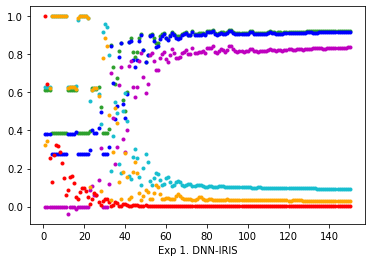

In [8]:
# loss 归一化
max_loss = 0
max_MS_loss = 0
max_train_acc = 0
max_F1 = 0
max_MCC = 0
max_Score = 0

for i in range(len(turns_record)):
    if loss_record[i] > max_loss:
        max_loss = loss_record[i]
    if MS_loss_record[i] > max_MS_loss:
        max_MS_loss = MS_loss_record[i]
    if Score_record[i] > max_Score:
        max_Score = Score_record[i]    

for i in range(len(loss_record)):
    loss_record[i] = loss_record[i]/max_loss
    MS_loss_record[i] = MS_loss_record[i]/max_MS_loss
    Score_record[i] = Score_record[i]/max_Score
    
plt.plot(turns_record, train_acc_record, '.', color = 'tab:green', label='ACC')
plt.plot(turns_record, F1_record, '.', color = 'b', label='F1') # lightpink
plt.plot(turns_record, MCC_record, '.', color = 'm', label='MCC')
plt.plot(turns_record, MS_loss_record, '.', color = 'tab:cyan', label='MS') # turquoise
plt.plot(turns_record, loss_record, '.', color = 'r', label='CE') # blueviolet
plt.plot(turns_record, Score_record, '.', color = 'orange', label='MPWS')

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

LABEL = 'Exp 1'
plt.xlabel(f"{LABEL}. {NAME}")

plt.savefig(f'../Savefig/{LABEL}.png', bbox_inches='tight', dpi=600)  # 保存该图片
plt.show()

In [9]:
import pandas as pd

train_acc_record_df = pd.DataFrame(train_acc_record)
F1_record_df = pd.DataFrame(F1_record)
MCC_record_df = pd.DataFrame(MCC_record)
MS_loss_record_df = pd.DataFrame(MS_loss_record)
loss_record_df = pd.DataFrame(loss_record)
Score_record_df = pd.DataFrame(Score_record)

data_df = pd.concat([train_acc_record_df, F1_record_df, MCC_record_df, MS_loss_record_df, loss_record_df, Score_record_df], axis=1)
data_df.columns = ['Accuracy', 'F1-score', 'MCC', 'Mean Squared', 'Cross Entropy', 'MPWS']  # head

writer = pd.ExcelWriter(f"../Records/{LABEL}. {NAME}.xlsx")
data_df.to_excel(writer,'page_1')
writer.save()
